**Dependencies**

In [1]:
from DataDownload import *
from PreProcessing import *
from EventIdentification import *
from CataloguedEvents import *
from PostProcessing import *
import matplotlib.pyplot as plt
from obspy import UTCDateTime


**Initiating Parameters For The Day**

In [2]:
date = UTCDateTime("2024-04-23") 

# station = ['GB', 'EDMD', 'IRIS']
station = ['AM','R50D6','https://data.raspberryshake.org']

# Try to download data and return availability for the date
data_available = download_seismic_data(date, station)

# Get the coordination for the station
station_coordinates = get_coordinates(station)

# Set global earthquake catalogue provider
providers = ["IRIS", "USGS", "EMSC"]

Data for 2024-04-23 already exist.



**Original Stream**

1 Trace(s) in Stream:
AM.R50D6.00.EHZ | 2024-04-22T23:00:00.004000Z - 2024-04-24T01:00:00.004000Z | 100.0 Hz, 9360001 samples


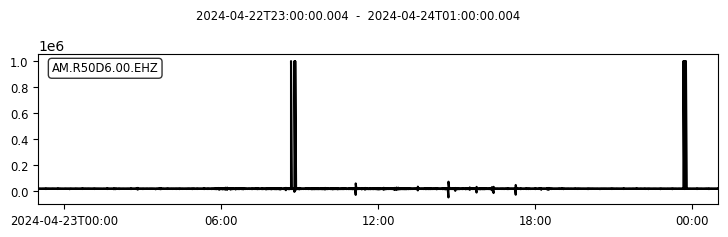

In [3]:
# Get stream from mseed file using date and st
stream = get_stream(date, station)
print(stream)

# Before processing
stream.plot()
plt.show()
plt.close()

**Processed Stream**

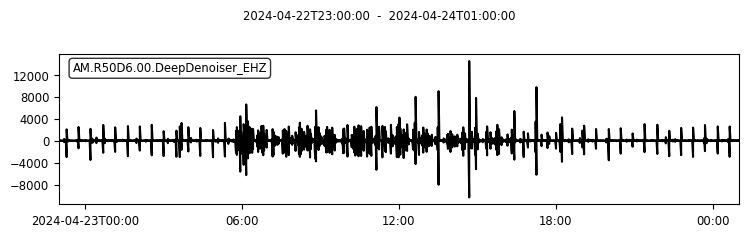

In [4]:
processed_stream = stream_process(stream)
processed_stream = deep_denoiser(processed_stream)
processed_stream.plot()
plt.show()
plt.close()

**Create a DataFrame for Events Identified Pretrained Deep Learning Model**

In [5]:
df_detected = detect_pretrained_picker(processed_stream)

In [6]:
df_detected

,peak_time,peak_confidence,phase
0,2024-04-22T23:01:06.000000Z,0.699751,P
1,2024-04-22T23:01:06.970000Z,0.230015,P
2,2024-04-22T23:01:11.100000Z,0.546595,S
3,2024-04-22T23:01:24.220000Z,0.104991,P
4,2024-04-22T23:02:23.090000Z,0.582724,P
...,...,...,...
1414,2024-04-24T00:37:11.600000Z,0.792975,P
1415,2024-04-24T00:37:12.020000Z,0.557688,S
1416,2024-04-24T00:39:01.340000Z,0.100909,S
1417,2024-04-24T00:50:23.100000Z,0.233176,P


**Find Earthquake From Catalogue**

In [7]:
catalogued_earthquakes = find_earthquakes(
    catalogue_providers= providers,
    coordinates = station_coordinates ,
    date = date,
    radmin=0,
    radmax=90,
    minmag=5,
    maxmag=10
)

print_catalogued(catalogued_earthquakes)

Events received from IRIS.
5 Event(s) in Catalog:
2024-04-23T15:40:05.079000Z | +38.158,  -30.835 | 5.2  Mww
2024-04-23T13:05:39.336000Z | +50.100,  -28.970 | 5.0  mww
2024-04-23T02:21:00.008000Z | +23.833, +121.610 | 5.2  Mwr
2024-04-23T00:11:02.661000Z | +23.898, +121.598 | 5.2  mb
2024-04-23T00:04:05.608000Z | +23.803, +121.676 | 5.8  mww



**Create a DataFrame for Catalogued Events with Predicted Arrival Times**

In [8]:
df_catalogued = create_df_with_prediction(catalogued_earthquakes, station_coordinates)
df_catalogued

,time,lat,long,mag,mag_type,P_predict,S_predict,catalogued,detected,P_detected,S_detected
0,2024-04-23T15:40:05.079000,38.1576,-30.8347,5.2,Mww,2024-04-23T15:45:38.589923,2024-04-23T15:50:13.947963,True,False,None,None
1,2024-04-23T13:05:39.336000,50.0999,-28.9704,5.0,mww,2024-04-23T13:09:42.848903,2024-04-23T13:13:21.000711,True,False,None,None
2,2024-04-23T02:21:00.008000,23.8333,121.6102,5.2,Mwr,2024-04-23T02:33:49.295674,2024-04-23T02:44:32.282826,True,False,None,None
3,2024-04-23T00:11:02.661000,23.8982,121.5981,5.2,mb,2024-04-23T00:23:51.101729,2024-04-23T00:34:33.407662,True,False,None,None
4,2024-04-23T00:04:05.608000,23.8026,121.6764,5.8,mww,2024-04-23T00:16:54.643660,2024-04-23T00:27:37.526696,True,False,None,None


**Compare DataFrames And Merge Events Detected In Catalogue**

In [9]:
result_df = match_and_merge(df_catalogued, df_detected, time_tolerance = 10)
print_statistics(result_df)

Detected in Catalogue: 3
Not Detected in Catalogue: 2
Detected but Not in Catalogue: 1416



**DataFrame Containing All Events For The Day Categorized**

In [10]:
result_df 

,time,lat,long,mag,mag_type,P_predict,S_predict,catalogued,detected,P_detected,S_detected,peak_confidence
0,2024-04-23T15:40:05.079000,38.1576,-30.8347,5.2,Mww,2024-04-23T15:45:38.589923,2024-04-23T15:50:13.947963,True,False,None,None,NaN
1,2024-04-23T13:05:39.336000,50.0999,-28.9704,5.0,mww,2024-04-23T13:09:42.848903,2024-04-23T13:13:21.000711,True,True,2024-04-23T13:09:48.950000,None,0.703398
2,2024-04-23T02:21:00.008000,23.8333,121.6102,5.2,Mwr,2024-04-23T02:33:49.295674,2024-04-23T02:44:32.282826,True,True,2024-04-23T02:33:40.040000,None,0.859432
3,2024-04-23T00:11:02.661000,23.8982,121.5981,5.2,mb,2024-04-23T00:23:51.101729,2024-04-23T00:34:33.407662,True,True,2024-04-23T00:23:54.120000,None,0.594742
4,2024-04-23T00:04:05.608000,23.8026,121.6764,5.8,mww,2024-04-23T00:16:54.643660,2024-04-23T00:27:37.526696,True,False,None,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,2024-04-24T00:37:11.600000,None,0.792975
1417,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,None,2024-04-24T00:37:12.020000,0.557688
1418,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,None,2024-04-24T00:39:01.340000,0.100909
1419,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,2024-04-24T00:50:23.100000,None,0.233176


**Using Confidence Score Threshold To Filter Out False Positives**

In [11]:
result_df = filter_confidence(result_df, confidence_threshold = 0.7)
print_statistics(result_df)

Detected in Catalogue: 3
Not Detected in Catalogue: 2
Detected but Not in Catalogue: 193



**Visualize Successfully Detected Events From Catalogue**

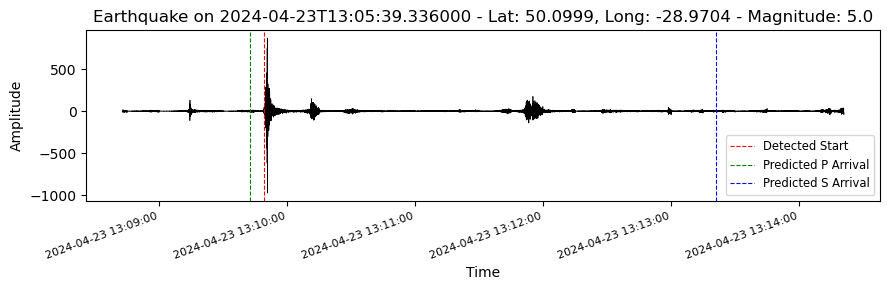

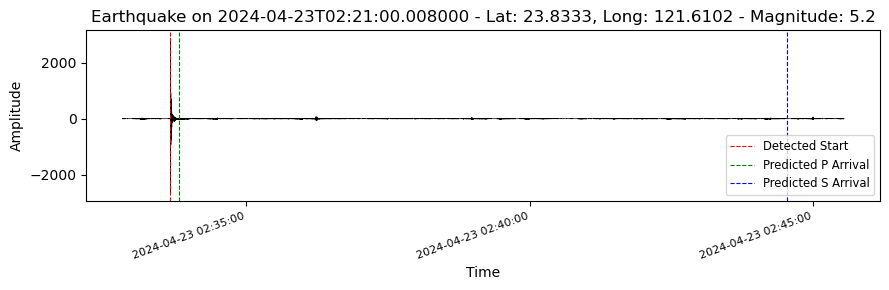

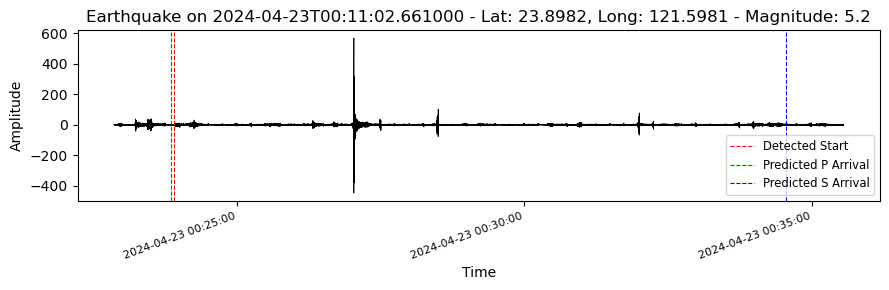

In [12]:
catalogued_and_detected_plot(result_df, processed_stream)